# Summary
The goal of this portion of our analysis is to measure how Area Deprivation correlates with access to a High-Volume Parathyroid Surgeon (HVS). This analysis will follow these steps:
1. Load and combine all relevant data
2. Examine the relationship between ADI and distance to surgeon
3. Group neighborhoods and physicians by health referral region and repeat analysis
4. <strike>Characterize the population that each physician is closest to</strike>



    
##### Possible:
- What proportion of the population do the ADI percentiles make up?
- What proportion of the population do physicians who predominantly care for high-ADI patients care for?
   

In [1]:
#Import modules and create necessary directories

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np
import os

required_directories = [
    "helper_functions",
    "raw_data",
    "raw_data/Crosswalk",
    "processed_data",
    "Images/Analytic/supplimentary"
]

for directory in required_directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Step 1.1
### Read in data for ADI for every FIPS code and Tract
**Data:** <a href="https://www.neighborhoodatlas.medicine.wisc.edu/" target="_None">https://www.neighborhoodatlas.medicine.wisc.edu/</a>
<br><br>
*Census tracts are the first 11 digits of the FIPS code, and is the most fine data that was reported by all data we used. As each 12 digit FIPS code is considered as a "neighborhood" (by the ADI), discreppancies between distances between neighborhoods within a tract will be small.*
<br><br>
*The first two digits of a FIPS code indicate its state. We restricted our analysis to the **contiguous United States**, and thus excluded all **territories** (State FIPS > 56), as well as **Alaska** and **Hawaii** (State FIPS 2 and 15, respectively).
<br><br>
Also note, the US reported **84,414** census tracts in 2020, and **73,057** in 2010. Part of the discreppancy comes from dropping Alaska and Hawaii, which accounts for ~250 tracts. The rest is due to the limitations of the Neighborhood Atlas.*

In [3]:
#Import and clean the ADI data
adi = pd.read_csv("raw_data/fips_adi.csv", dtype={"FIPS": "string"})
adi["TRACT"] = adi["FIPS"].apply(lambda val: val[:11])
adi["STATE"] = adi["FIPS"].apply(lambda val: int(val[:2]))
adi = adi[(adi["STATE"] <= 56) & (~adi["STATE"].isin([2, 15]))].reset_index(drop=True)#Drop all but the continental US
adi = adi[pd.to_numeric(adi["ADI_NATRANK"], errors="coerce").notnull()]
adi = adi.filter(["FIPS", "TRACT", "ADI_NATRANK"])

print(f"There are {len(adi['FIPS'].unique())} unique neighborhoods and {len(adi['TRACT'].unique())} unique tracts.")
adi


There are 211721 unique neighborhoods and 71263 unique tracts.


,FIPS,TRACT,ADI_NATRANK
0,010010201001,01001020100,89
1,010010201002,01001020100,52
2,010010202001,01001020200,88
3,010010202002,01001020200,82
4,010010203001,01001020300,71
...,...,...,...
216325,560459511001,56045951100,58
216326,560459511002,56045951100,42
216327,560459513001,56045951300,83
216328,560459513002,56045951300,63


# Step 1.2

### Get neighborhood FIPS code for each physician's practice
**Data:**<a href="https://data.cms.gov/provider-summary-by-type-of-service/medicare-physician-other-practitioners/medicare-physician-other-practitioners-by-provider-and-service">https://data.cms.gov/provider-summary-by-type-of-service/</a>
<br><br>
*As with before, the neighborhood-level fips are coerced into census tracts. As both are fairly small, the difference is negligible.*
<br><br>
*Physician FIPS code were found by:
    <ol>
    <li> passing the physician adresses in spreadsheet form into <a href="https://www.geocod.io/upload/" target="_None">https://www.geocod.io/upload/</a> in order to find their latitude and longitude
    <li> running `./helper_functions/locate_physicians.py` to add FIPS codes based on latitude and longitude*</li>
    </ol>

In [4]:
#Import data and obtain census tract; export physician tracts
claims_data = pd.read_csv("processed_data/Physician_Data.csv", dtype={"Rndrng_NPI":"string"})
claims_data["Rndrng_Prvdr_Tract"] = claims_data["Rndrng_Prvdr_Fips"].apply(lambda val: str(val)[:11])
physician_tracts = set(claims_data["Rndrng_Prvdr_Tract"])
with open("processed_data/Phys_Tracts.txt", 'w') as out_file:
    out_file.write(','.join(list(physician_tracts)))
claims_data

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,Avg_Sbmtd_Chrg,Avg_Mdcr_Alowd_Amt,Avg_Mdcr_Pymt_Amt,Avg_Mdcr_Stdzd_Amt,Latitude,Longitude,Rndrng_Prvdr_Fips,Lat,Long,Rndrng_Prvdr_Tract
0,1194746966,Politz,Douglas,E,M.D.,M,I,2400 Cypress Glen Dr.,NaN,Wesley Chapel,...,1.00,1.00,1.00,1.00,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106
1,1033166277,Mitchell,Jamie,C,M.D.,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,1.00,1.00,1.00,1.00,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106
2,1134369002,Parrack,Kevin,M,MD,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,1.00,1.00,1.00,1.00,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106
3,1255640124,Boone,Deva,NaN,MD,F,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,1.00,1.00,1.00,1.00,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106
4,1285711275,Ruan,Daniel,T,M.D.,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,1.00,1.00,1.00,1.00,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,1982851176,Albert,Scott,P,MD,M,I,750 E Adams St,Dept Of Surgery,Syracuse,...,1821.00,939.91,751.69,787.46,43.042514,-76.141056,360670043011,43.0,-76.0,36067004301
441,1477782100,Dhir,Mashaal,NaN,MBBS,M,I,750 E Adams St,NaN,Syracuse,...,2433.45,939.91,751.69,787.46,43.042514,-76.141056,360670043011,43.0,-76.0,36067004301
442,1609096775,Dickson,Paxton,V,M.D.,M,I,7945 Wolf River Blvd,Suite 289,Germantown,...,2680.00,867.18,692.09,751.67,35.110956,-89.798631,471570213511,35.0,-90.0,47157021351
443,1710112214,Wachtel,Heather,NaN,MD,F,I,3400 Spruce St,NaN,Philadelphia,...,6994.00,1002.84,799.01,787.46,39.950014,-75.194092,421010369013,40.0,-75.0,42101036901


/tmp/ipykernel_435610/139547097.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lorenz_data.loc[-1] = 0


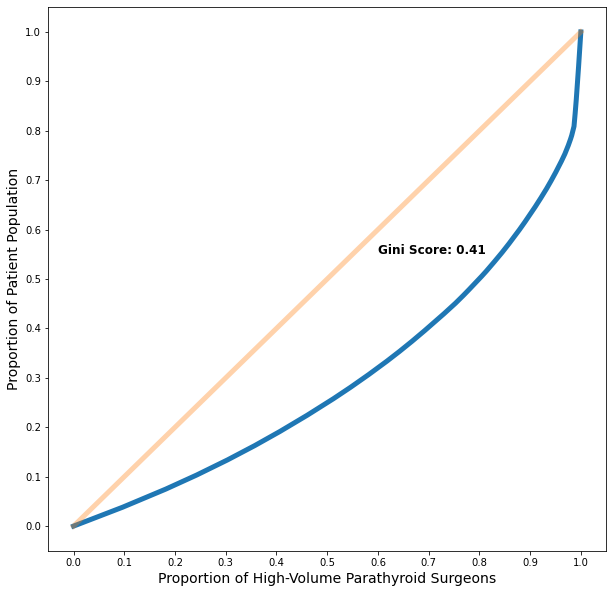

In [5]:
#Graph of Lorenz curve of Physician care per population percentage
#https://zhiyzuo.github.io/Plot-Lorenz/
plt.rcParams["figure.figsize"]=[10,10]
lorenz_data = claims_data[["Tot_PTX"]]
lorenz_data.loc[-1] = 0
lorenz_data = lorenz_data.sort_values("Tot_PTX").reset_index(drop=True)
lorenz_data["Tot_PTX"] = lorenz_data["Tot_PTX"].cumsum() / lorenz_data["Tot_PTX"].sum()
lorenz_data["Tot_HVS"] = lorenz_data.index / (len(lorenz_data) - 1)

area_under_curve = np.trapz(lorenz_data["Tot_PTX"]) / len(lorenz_data)
gini_score = 1 - area_under_curve / 0.5

plt.plot("Tot_HVS", "Tot_PTX",data=lorenz_data, linewidth=5)
plt.plot(lorenz_data["Tot_HVS"], lorenz_data["Tot_HVS"], linewidth=5, alpha=0.35)
plt.text(0.6, 0.55, f"Gini Score: {round(gini_score, 2)}", fontweight="bold", fontsize=12)


plt.xlabel("Proportion of High-Volume Parathyroid Surgeons", fontsize=14)
plt.ylabel("Proportion of Patient Population", fontsize=14)
plt.xticks(np.array(range(11))/10)
plt.yticks(np.array(range(11))/10)

plt.savefig("Images/Analytic/Gini_Score_Physicians.png", dpi=300, facecolor='white')
plt.show()

# Step 1.3

### Get distance between FIPS codes
**Data:** <a href="https://www.nber.org/research/data/tract-distance-database">https://www.nber.org/research/data/tract-distance-database</a>
<br><br>
*This data is only reported per tract, and is the limiting factor for the specificity of this data. As the difference from even one tract to another is rarely greater than 1 mile, the difference betweeen two block groups (approx. neighborhoods) is negligible.*
<br><br>
*As the raw dataset is quite large (~150M rows, ~8.2GB), it had to be modified beforehad in order to load into a pandas dataframe. I managed this with `./helper_functions/filter_fips_dist.cpp`, which did the following:*
- Concatenate columns to make the data readable by pandas
- Filter out all census tracts where the destination (tract2) is NOT one of the HVS's tracts
- Select only the relationships that have the shortest distance to any physician, for each tract

In [6]:
%%bash
if [ ! -f "processed_data/fips_dist.csv" ]
then 
    g++ helper_functions/filter_fips_dist.cpp -o h\elper_functions/filter_fips_dist.out
    echo "compiled!"
    ./helper_functions/filter_fips_dist.out
else
    echo "File already exists. No need to run again."
fi

compiled!
There are 335 physician tracts.
There are 74001 adi tracts.
Line 1M
Line 2M
Line 3M
Line 4M
Line 5M
Line 6M
Line 7M
Line 8M
Line 9M
Line 10M
Line 11M
Line 12M
Line 13M
Line 14M
Line 15M
Line 16M
Line 17M
Line 18M
Line 19M
Line 20M
Line 21M
Line 22M
Line 23M
Line 24M
Line 25M
Line 26M
Line 27M
Line 28M
Line 29M
Line 30M
Line 31M
Line 32M
Line 33M
Line 34M
Line 35M
Line 36M
Line 37M
Line 38M
Line 39M
Line 40M
Line 41M
Line 42M
Line 43M
Line 44M
Line 45M
Line 46M
Line 47M
Line 48M
Line 49M
Line 50M
Line 51M
Line 52M
Line 53M
Line 54M
Line 55M
Line 56M
Line 57M
Line 58M
Line 59M
Line 60M
Line 61M
Line 62M
Line 63M
Line 64M
Line 65M
Line 66M
Line 67M
Line 68M
Line 69M
Line 70M
Line 71M
Line 72M
Line 73M
Line 74M
Line 75M
Line 76M
Line 77M
Line 78M
Line 79M
Line 80M
Line 81M
Line 82M
Line 83M
Line 84M
Line 85M
Line 86M
Line 87M
Line 88M
Line 89M
Line 90M
Line 91M
Line 92M
Line 93M
Line 94M
Line 95M
Line 96M
Line 97M
Line 98M
Line 99M
Line 100M
Line 101M
Line 102M
Line 103M
Line 104

As mentioned by the command above, only **39** neighborhoods did not have a distance associated with them. Of these, **24** were within the contiguous United States. FIPS codes are such a fine level of detail that they change periodically

In [7]:
#Read in processed data
fips_dist = pd.read_csv("processed_data/fips_dist.csv", dtype={"tract1":"string", "tract2":"string"})
fips_dist["tract1"]=fips_dist["tract1"].apply(lambda row: row.zfill(11))
fips_dist["tract2"]=fips_dist["tract2"].apply(lambda row: row.zfill(11))
fips_dist

,tract1,mi_to_tract,tract2
0,01001020100,89.303,13215000900
1,01001020200,88.267,13215000900
2,01001020300,87.526,13215000900
3,01001020400,86.657,13215000900
4,01001020500,85.355,13215000900
...,...,...,...
56835,56041975200,88.400,49035101700
56836,56041975300,65.913,49035101700
56837,56041975400,60.463,49035101700
56838,56045951100,68.519,46103010905


# Step 1.4

### Merge data

In [9]:
#Merging ADI and distance data
adi_dist = adi.merge(fips_dist, how="left", left_on="TRACT", right_on="tract1")
adi_dist.drop(columns="tract1", inplace=True)
adi_dist["ADI_NATRANK"]=adi_dist["ADI_NATRANK"].astype(int)

adi_dist.head(40)

,FIPS,TRACT,ADI_NATRANK,mi_to_tract,tract2
0,010010201001,01001020100,89,89.303,13215000900
1,010010201002,01001020100,52,89.303,13215000900
2,010010202001,01001020200,88,88.267,13215000900
3,010010202002,01001020200,82,88.267,13215000900
4,010010203001,01001020300,71,87.526,13215000900
5,010010203002,01001020300,75,87.526,13215000900
6,010010204001,01001020400,59,86.657,13215000900
7,010010204002,01001020400,56,86.657,13215000900
8,010010204003,01001020400,71,86.657,13215000900
9,010010204004,01001020400,71,86.657,13215000900


In [10]:
#Merge physician data to destination
adi_dist = adi_dist.merge(claims_data, how="left", left_on="tract2", right_on="Rndrng_Prvdr_Tract")
adi_dist.dropna(subset = ["FIPS","TRACT","tract2","Rndrng_NPI"], inplace=True)

adi_dist = adi_dist[["FIPS", "TRACT", "ADI_NATRANK", "mi_to_tract", "Rndrng_NPI", "Rndrng_Prvdr_Tract"]]
adi_dist = adi_dist.astype({"Rndrng_NPI":"string"})
adi_dist

,FIPS,TRACT,ADI_NATRANK,mi_to_tract,Rndrng_NPI,Rndrng_Prvdr_Tract
0,010010201001,01001020100,89,89.303,1841365525,13215000900
1,010010201002,01001020100,52,89.303,1841365525,13215000900
2,010010202001,01001020200,88,88.267,1841365525,13215000900
3,010010202002,01001020200,82,88.267,1841365525,13215000900
4,010010203001,01001020300,71,87.526,1841365525,13215000900
...,...,...,...,...,...,...
265481,560459511001,56045951100,58,68.519,1174550628,46103010905
265482,560459511002,56045951100,42,68.519,1174550628,46103010905
265483,560459513001,56045951300,83,52.420,1174550628,46103010905
265484,560459513002,56045951300,63,52.420,1174550628,46103010905


# Step 2.1

### Visualize the data

<em> The ranking data is split into four quartiles:
    <ol><li>**V**ery **A**dvantaged (0-25%)</li>
        <li>**S**omewhat **A**dvantaged (26-50%)</li>
        <li>**S**omewhat **D**isadvantaged (51-75%)</li>
        <li>**V**ery **D**isadvantaged (76-100%)</li>
    </ol>
<em>

In [11]:
#Cutting into four quartiles
adi_dist["ADI_NATRANK"] = adi_dist["ADI_NATRANK"].astype(int)
adi_dist["QUARTILE"] = pd.cut(adi_dist["ADI_NATRANK"],bins=[0, 25, 50, 75, 100],labels=["VA", "SA", "SD", "VD"])
adi_dist

,FIPS,TRACT,ADI_NATRANK,mi_to_tract,Rndrng_NPI,Rndrng_Prvdr_Tract,QUARTILE
0,010010201001,01001020100,89,89.303,1841365525,13215000900,VD
1,010010201002,01001020100,52,89.303,1841365525,13215000900,SD
2,010010202001,01001020200,88,88.267,1841365525,13215000900,VD
3,010010202002,01001020200,82,88.267,1841365525,13215000900,VD
4,010010203001,01001020300,71,87.526,1841365525,13215000900,SD
...,...,...,...,...,...,...,...
265481,560459511001,56045951100,58,68.519,1174550628,46103010905,SD
265482,560459511002,56045951100,42,68.519,1174550628,46103010905,SA
265483,560459513001,56045951300,83,52.420,1174550628,46103010905,VD
265484,560459513002,56045951300,63,52.420,1174550628,46103010905,SD


In [12]:
#This data will be used in Step 3, and will be saved into physicians_dists
physician_dists = adi_dist.copy()
#Condense any duplicate physicians into one row, in a comma-separated list
adi_dist=adi_dist.groupby("FIPS").agg({"TRACT":"first", "ADI_NATRANK":"first", "Rndrng_NPI":', '.join, "mi_to_tract":"first", "Rndrng_Prvdr_Tract":"first", "QUARTILE":"first"})
adi_dist

,TRACT,ADI_NATRANK,Rndrng_NPI,mi_to_tract,Rndrng_Prvdr_Tract,QUARTILE
FIPS,,,,,,
010010201001,01001020100,89,1841365525,89.303,13215000900,VD
010010201002,01001020100,52,1841365525,89.303,13215000900,SD
010010202001,01001020200,88,1841365525,88.267,13215000900,VD
010010202002,01001020200,82,1841365525,88.267,13215000900,VD
010010203001,01001020300,71,1841365525,87.526,13215000900,SD
...,...,...,...,...,...,...
560459511001,56045951100,58,1174550628,68.519,46103010905,SD
560459511002,56045951100,42,1174550628,68.519,46103010905,SA
560459513001,56045951300,83,1174550628,52.420,46103010905,VD


In [13]:
output_data = adi_dist.copy()
output_data.index.names = ["Neighborhood FIPS"]
output_data.columns = ["Neighborhood Tract", "ADI National Ranking", "Closest Physician NPI", "Distance to Physician (mi)", "Physician Tract", "ADI Quartile"]
output_data = output_data[["Neighborhood Tract", "ADI National Ranking", "ADI Quartile", "Distance to Physician (mi)", "Physician Tract", "Closest Physician NPI"]]

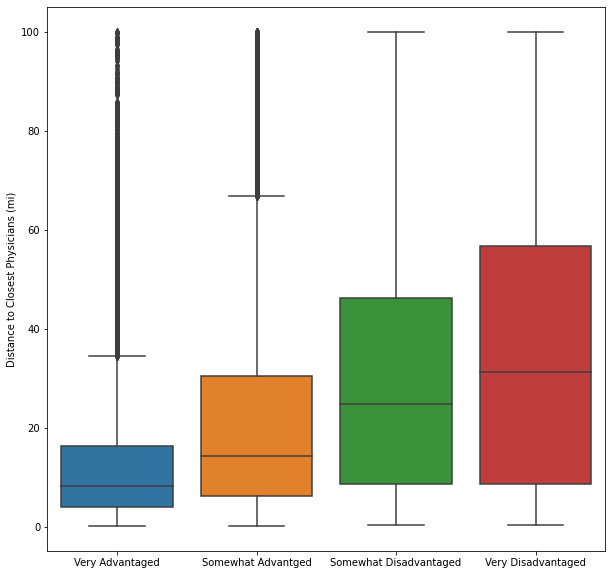

In [14]:
#Creating boxplot of data
plot = sns.boxplot(data=adi_dist, y="mi_to_tract", x="QUARTILE")
plot.set_ylabel("Distance to Closest Physicians (mi)")
plot.set_xticklabels(["Very Advantaged", "Somewhat Advantged", "Somewhat Disadvantaged", "Very Disadvantaged"])
plot.set_xlabel(None)
plt.savefig("Images/Analytic/dist_by_quartile_box.png", dpi=300)
plt.show()
# adi_dist.boxplot("mi_to_tract", "QUARTILE")

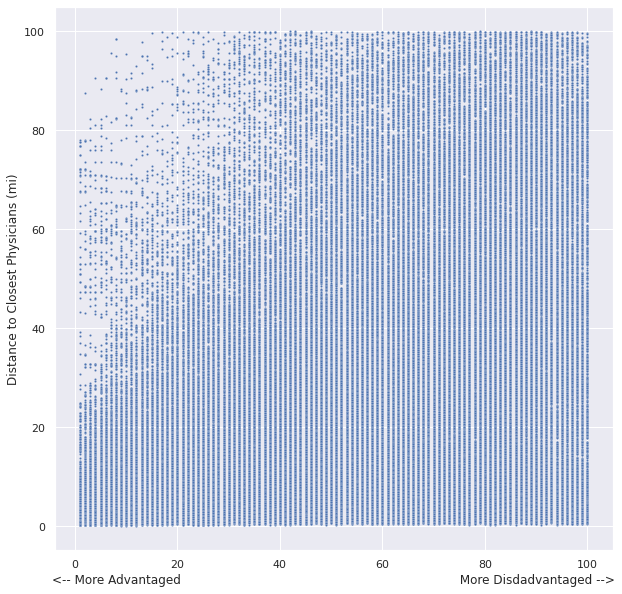

In [15]:
#Creating scatterplot of data
sns.set(rc={'figure.figsize':(10,10)})

plot = sns.scatterplot(data=adi_dist, x="ADI_NATRANK", y="mi_to_tract", s=5)
plot.set_ylabel("Distance to Closest Physicians (mi)")
plot.set_xlabel("<-- More Advantaged                                                                        More Disdadvantaged -->")
plt.savefig("Images/Analytic/dist_by_adi_scatter.png", dpi=300)
plt.show()

# Step 2.2 (Skipped)

<s>### Visualize data for neighborhoods greater than 100 miles away from the nearest HVS</s>

In [16]:
# #Cutting into four quartiles
# more_than_100mi["ADI_NATRANK"] = more_than_100mi["ADI_NATRANK"].astype(int)
# more_than_100mi["QUARTILE"] = pd.cut(more_than_100mi["ADI_NATRANK"],bins=[0, 25, 50, 75, 100],labels=["VA", "SA", "SD", "VD"])
# more_than_100mi.drop(columns=["TRACT", "mi_to_tract", "tract2"], inplace=True)
# more_than_100mi

In [17]:
# more_than_100mi[["FIPS", "QUARTILE"]].groupby("QUARTILE").count().plot(kind="bar")
# plt.show()

# Step 2.3
### Run statistical tests to determine significance

*As will be shown, the data is not normally distributed (right skewed), so nonparametric tests will be used*

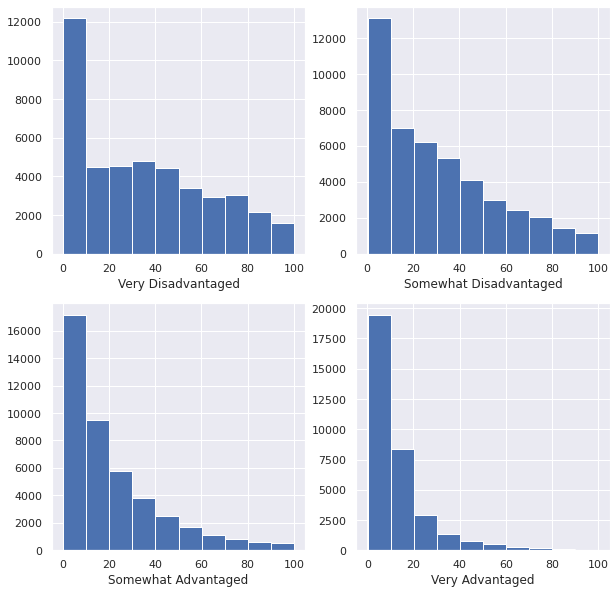

In [18]:
#Plotting histograms to check for normality
plt.subplot(2,2,1)
plt.hist(adi_dist[adi_dist["QUARTILE"] == 'VD']["mi_to_tract"])
plt.xlabel("Very Disadvantaged")
plt.subplot(2,2,2)
plt.hist(adi_dist[adi_dist["QUARTILE"] == 'SD']["mi_to_tract"])
plt.xlabel("Somewhat Disadvantaged")
plt.subplot(2,2,3)
plt.hist(adi_dist[adi_dist["QUARTILE"] == 'SA']["mi_to_tract"])
plt.xlabel("Somewhat Advantaged")
plt.subplot(2,2,4)
plt.hist(adi_dist[adi_dist["QUARTILE"] == 'VA']["mi_to_tract"])
plt.xlabel("Very Advantaged")
plt.savefig("Images/Analytic/dist_by_adi_bar.png", dpi=200)
plt.show()

In [19]:
#As data is not normally distributed, nonparametric tests will be used
#Finding measures of central tendency...

quarts = lambda dists: f"{round(dists.quantile(0.25), 2)}—{round(dists.quantile(0.75), 2)}" 

adi_dist.groupby("QUARTILE").agg(
    count_of_tracts=("Rndrng_NPI", "count"),
    median_dist=("mi_to_tract", "median"),
    IQR_dist=("mi_to_tract", quarts)
)

,count_of_tracts,median_dist,IQR_dist
QUARTILE,,,
VA,34042,8.3267,4.02—16.22
SA,43496,14.2940,6.29—30.48
SD,45796,24.7790,8.57—46.28
VD,43565,31.3630,8.57—56.62


In [20]:
#Performing a Kruskall Wallis Test
VD_SD = stats.ttest_ind(adi_dist[adi_dist["QUARTILE"] == "VD"]["mi_to_tract"], adi_dist[adi_dist["QUARTILE"] == "SD"]["mi_to_tract"])
VA_VD = stats.ttest_ind(adi_dist[adi_dist["QUARTILE"] == "VD"]["mi_to_tract"], adi_dist[adi_dist["QUARTILE"] == "VA"]["mi_to_tract"])

ALL = stats.kruskal(*[group["mi_to_tract"].values for name, group in adi_dist.groupby("QUARTILE")])

print("P VALUES")
print(f"VD_SD: {VD_SD}")
print(f"VA_VD: {VA_VD}")

print(f"overall: {ALL}")


P VALUES
VD_SD: Ttest_indResult(statistic=27.53092915787967, pvalue=3.717771905881186e-166)
VA_VD: Ttest_indResult(statistic=137.25311690448473, pvalue=0.0)
overall: KruskalResult(statistic=18451.521464471632, pvalue=0.0)


# Step 3
### Group neighborhoods by health referral region

One limitation of this analysis is that it assumes that patients seek care at whichever High-Volume Surgeon is geographically nearest. With that in mind, we grouped the neighborhoods and HVS by Hospital Referral Region (HRR) to see if this assumption was safe.

*Information about the Hospital Referral Region can be found <a href="https://www.allhealthpolicy.org/glossary/hospital-referral-region/#:~:text=These%20regions%20are%20defined%20by,HRRs%20can%20cross%20state%20lines.">here</a>.*

# Step 3.1
### Merge Crosswalk data with adi and physicians

In [21]:
#Read in tract to zip crosswalk and clean data
tract_to_zip = pd.read_csv("raw_data/Crosswalk/tract_zip.csv", dtype={"TRACT":"string", "ZIP":"string"})
tract_to_zip = tract_to_zip.sort_values(["TRACT", "TOT_RATIO"], ascending=[True, False])
tract_to_zip = tract_to_zip.drop_duplicates(subset="TRACT", keep="first", ignore_index=True)
tract_to_zip

,TRACT,ZIP,TOT_RATIO
0,01001020100,36067,1.000000
1,01001020200,36067,1.000000
2,01001020300,36067,1.000000
3,01001020400,36066,0.929902
4,01001020500,36066,0.778459
...,...,...,...
73486,78030960800,00802,1.000000
73487,78030960900,00802,1.000000
73488,78030961000,00802,1.000000
73489,78030961100,00802,1.000000


In [22]:
#Ensure that the FIPS and ZIPs overlap sufficiently to make useful groupings
plt.rcParams["figure.figsize"] = [6,6]
tract_to_zip.hist(column="TOT_RATIO")
plt.title("Count of Tracts by Proportion in Best-Fit Zip Code", fontsize=14)
plt.xlabel("Proportion of FIPS in ZIP code", fontsize=12)
plt.text(x=0.1, y = 38000, s="Almost all of the neighborhoods lie \nmostly or entirely in a           --->\nsingle zip code area.")
plt.savefig("Images/Analytic/supplimentary/fips_fit_in_zip.png", dpi=300)
print("Figure saved to Images/Analytic/supplimentary/fips_fit_in_zip.png")
plt.close()

tract_to_zip.drop(columns = "TOT_RATIO", inplace=True)

Figure saved to Images/Analytic/supplimentary/fips_fit_in_zip.png


In [23]:
#Merge ADI data with this crosswalk to group FIPS codes by zip code
adi_to_zip = adi.merge(tract_to_zip, on="TRACT", how = "left")

In [24]:
#Some FIPS codes do not have a ZIP code. Characterize these, then ignore them.
no_zip = adi_to_zip[adi_to_zip["ZIP"].isna()]
no_zip["ADI_NATRANK"] = no_zip["ADI_NATRANK"].astype(int)
no_zip.hist(column="ADI_NATRANK")

plt.rcParams["figure.figsize"]=[7,5]
plt.xlabel("ADI Percentile", fontsize=14)
plt.title("Number of FIPS w/o ZIP Code", fontsize=16)
plt.savefig("Images/Analytic/supplimentary/FIPS_no_ZIP.png", dpi=300)
print("Figure Saved to Images/Analytic/supplimentary/FIPS_no_ZIP.png")
plt.close()

adi_to_zip = adi_to_zip.dropna().reset_index(drop=True)

/tmp/ipykernel_435610/1113225573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_zip["ADI_NATRANK"] = no_zip["ADI_NATRANK"].astype(int)


Figure Saved to Images/Analytic/supplimentary/FIPS_no_ZIP.png


In [25]:
#Read in ZIP to HRR crosswalk and merge with adi_to_zip
zip_to_hrr = pd.read_csv("raw_data/Crosswalk/zip_hrr.csv", dtype={"ZIP":"string", "HRR":"string"})
adi_to_hrr = adi_to_zip.merge(zip_to_hrr, on="ZIP", how="left")
adi_to_hrr

,FIPS,TRACT,ADI_NATRANK,ZIP,HRR,city,state
0,010010201001,01001020100,89,36067,7,Montgomery,AL
1,010010201002,01001020100,52,36067,7,Montgomery,AL
2,010010202001,01001020200,88,36067,7,Montgomery,AL
3,010010202002,01001020200,82,36067,7,Montgomery,AL
4,010010203001,01001020300,71,36067,7,Montgomery,AL
...,...,...,...,...,...,...,...
211594,560459511001,56045951100,58,82701,457,Casper,WY
211595,560459511002,56045951100,42,82701,457,Casper,WY
211596,560459513001,56045951300,83,82701,457,Casper,WY
211597,560459513002,56045951300,63,82701,457,Casper,WY


In [26]:
#Merge zip_to_hrr with the claims data to group physicians by HRR
claims_data["Rndrng_Prvdr_Zip5"] = claims_data["Rndrng_Prvdr_Zip5"].astype(str)
claims_hrr = claims_data.merge(zip_to_hrr, left_on="Rndrng_Prvdr_Zip5", right_on="ZIP", how="left")
claims_hrr

,Rndrng_NPI,Rndrng_Prvdr_Last_Org_Name,Rndrng_Prvdr_First_Name,Rndrng_Prvdr_MI,Rndrng_Prvdr_Crdntls,Rndrng_Prvdr_Gndr,Rndrng_Prvdr_Ent_Cd,Rndrng_Prvdr_St1,Rndrng_Prvdr_St2,Rndrng_Prvdr_City,...,Latitude,Longitude,Rndrng_Prvdr_Fips,Lat,Long,Rndrng_Prvdr_Tract,ZIP,HRR,city,state
0,1194746966,Politz,Douglas,E,M.D.,M,I,2400 Cypress Glen Dr.,NaN,Wesley Chapel,...,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106,33613,141,Tampa,FL
1,1033166277,Mitchell,Jamie,C,M.D.,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106,33544,141,Tampa,FL
2,1134369002,Parrack,Kevin,M,MD,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106,33544,141,Tampa,FL
3,1255640124,Boone,Deva,NaN,MD,F,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106,33544,141,Tampa,FL
4,1285711275,Ruan,Daniel,T,M.D.,M,I,2400 Cypress Glen Dr,NaN,Wesley Chapel,...,28.191521,-82.372900,121010321061,28.0,-82.5,12101032106,33544,141,Tampa,FL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
440,1982851176,Albert,Scott,P,MD,M,I,750 E Adams St,Dept Of Surgery,Syracuse,...,43.042514,-76.141056,360670043011,43.0,-76.0,36067004301,13210,307,Syracuse,NY
441,1477782100,Dhir,Mashaal,NaN,MBBS,M,I,750 E Adams St,NaN,Syracuse,...,43.042514,-76.141056,360670043011,43.0,-76.0,36067004301,13210,307,Syracuse,NY
442,1609096775,Dickson,Paxton,V,M.D.,M,I,7945 Wolf River Blvd,Suite 289,Germantown,...,35.110956,-89.798631,471570213511,35.0,-90.0,47157021351,38138,379,Memphis,TN
443,1710112214,Wachtel,Heather,NaN,MD,F,I,3400 Spruce St,NaN,Philadelphia,...,39.950014,-75.194092,421010369013,40.0,-75.0,42101036901,19104,356,Philadelphia,PA


In [27]:
#Split adi_hrr data into two groups based on if they share an HRR with one of the physicians
phys_hrr = set(claims_hrr["HRR"])
no_hrr = adi_to_hrr[~adi_to_hrr["HRR"].isin(phys_hrr)].reset_index(drop=True)
yes_hrr = adi_to_hrr[adi_to_hrr["HRR"].isin(phys_hrr)].reset_index(drop=True)
print(f"Of the {len(adi_to_hrr)} neighborhoods,")
print(f"{round(len(yes_hrr) / len(adi_to_hrr), 3) * 100}% ({len(yes_hrr)}) shared an HRR with a HVS, and")
print(f"{round(len(no_hrr) / len(adi_to_hrr), 3) * 100}% ({len(no_hrr)}) did not share an HRR with a HVS.")

Of the 211599 neighborhoods,
74.6% (157928) shared an HRR with a HVS, and
25.4% (53671) did not share an HRR with a HVS.


# Step 3.2

### Characterize neighborhoods that did not share an HRR with an HVS

In [28]:
#Plot number of neighborhoods in an HRR without an HVS
plt.rcParams["figure.figsize"] = [10,6]
no_hrr["ADI_NATRANK"] = no_hrr["ADI_NATRANK"].astype(int)
no_hrr_counts = no_hrr["ADI_NATRANK"].value_counts().sort_index()
plt.plot(no_hrr_counts.index, no_hrr_counts.values)
plt.ylim([0,1950])
plt.title("Neighborhoods in HRR w/o HVS", fontsize=18)
plt.xlabel("ADI Ranking", fontsize=14)

#Plot summary line
no_hrr_line = np.polyfit(x=no_hrr_counts.index, y=no_hrr_counts.values, deg=1)
plt.plot(no_hrr_counts.index, no_hrr_line[0]*no_hrr_counts.index + no_hrr_line[1], color="blue", alpha = 0.2)
plt.text(x=22, y=1715, s=f"Line:\ny={round(no_hrr_line[0], 2)} * x + {round(no_hrr_line[1],2)}", fontweight="bold")


plt.savefig("Images/Analytic/supplimentary/FIPS_no_HRR.png", dpi=300)
plt.close()
print("Figure saved to Images/Analytic/supplimentary/FIPS_no_HRR.png")

Figure saved to Images/Analytic/supplimentary/FIPS_no_HRR.png


In [29]:
#Chart number of neighborhoods in an HRR without an HVS by quartile
no_hrr["QUARTILE"] = pd.cut(no_hrr["ADI_NATRANK"],bins=[0, 25, 50, 75, 100],labels=["VA", "SA", "SD", "VD"])
no_hrr["QUARTILE"].value_counts().plot.bar()
plt.title("Neighborhoods in HRR w/o HVS (by Quartile)", fontsize=18)
plt.xticks(rotation=0)
plt.savefig("Images/Analytic/supplimentary/FIPS_no_HRR_Quart.png", dpi=300)
plt.close()
print("Figure saved to Images/Analytic/supplimentary/FIPS_no_HRR_Quart.png")

Figure saved to Images/Analytic/supplimentary/FIPS_no_HRR_Quart.png


# Step 3.3

### Repeat full analysis for neighborhoods in HVS containing a HVS

*The analysis performed in **Step 2.1** will be repeated, ensuring that no patient is with a physician outside of their HRR*

In [30]:
hrr_dist = yes_hrr.merge(fips_dist, left_on="TRACT", right_on="tract1")
hrr_dist["ADI_NATRANK"]=hrr_dist["ADI_NATRANK"].astype(int)
hrr_dist["QUARTILE"] = pd.cut(hrr_dist["ADI_NATRANK"],bins=[0, 25, 50, 75, 100],labels=["VA", "SA", "SD", "VD"])
hrr_dist

,FIPS,TRACT,ADI_NATRANK,ZIP,HRR,city,state,tract1,mi_to_tract,tract2,QUARTILE
0,010059501001,01005950100,84,36027,2,Dothan,AL,01005950100,36.351,13215000900,VD
1,010059501002,01005950100,96,36027,2,Dothan,AL,01005950100,36.351,13215000900,VD
2,010059501003,01005950100,75,36027,2,Dothan,AL,01005950100,36.351,13215000900,SD
3,010059502001,01005950200,93,36016,2,Dothan,AL,01005950200,49.243,13215000900,VD
4,010059502003,01005950200,81,36016,2,Dothan,AL,01005950200,49.243,13215000900,VD
...,...,...,...,...,...,...,...,...,...,...,...
126914,560419754002,56041975400,49,82930,423,Salt Lake City,UT,56041975400,60.463,49035101700,SA
126915,560419754003,56041975400,59,82930,423,Salt Lake City,UT,56041975400,60.463,49035101700,SD
126916,560419754004,56041975400,48,82930,423,Salt Lake City,UT,56041975400,60.463,49035101700,SA
126917,560419754005,56041975400,73,82930,423,Salt Lake City,UT,56041975400,60.463,49035101700,SD


In [31]:
#Merge physician data to destination
hrr_dist = hrr_dist.merge(claims_hrr, how="left", left_on="tract2", right_on="Rndrng_Prvdr_Tract")
hrr_dist.dropna(subset = ["FIPS","TRACT","tract2","Rndrng_NPI"], inplace=True)

hrr_dist = hrr_dist[["FIPS", "TRACT", "ADI_NATRANK", "ZIP_x", "HRR_x", "mi_to_tract", "HRR_y", "ZIP_y", "Rndrng_NPI", "Rndrng_Prvdr_Tract", "Rndrng_Prvdr_Fips", "QUARTILE"]]
hrr_dist = hrr_dist.astype({"Rndrng_NPI":"string", "Rndrng_Prvdr_Fips":"string"})
hrr_dist

,FIPS,TRACT,ADI_NATRANK,ZIP_x,HRR_x,mi_to_tract,HRR_y,ZIP_y,Rndrng_NPI,Rndrng_Prvdr_Tract,Rndrng_Prvdr_Fips,QUARTILE
0,010059501001,01005950100,84,36027,2,36.351,146,31904,1841365525,13215000900,132150009002,VD
1,010059501002,01005950100,96,36027,2,36.351,146,31904,1841365525,13215000900,132150009002,VD
2,010059501003,01005950100,75,36027,2,36.351,146,31904,1841365525,13215000900,132150009002,SD
3,010059502001,01005950200,93,36016,2,49.243,146,31904,1841365525,13215000900,132150009002,VD
4,010059502003,01005950200,81,36016,2,49.243,146,31904,1841365525,13215000900,132150009002,VD
...,...,...,...,...,...,...,...,...,...,...,...,...
167065,560419754002,56041975400,49,82930,423,60.463,423,84102,1801986427,49035101700,490351017004,SA
167066,560419754003,56041975400,59,82930,423,60.463,423,84102,1801986427,49035101700,490351017004,SD
167067,560419754004,56041975400,48,82930,423,60.463,423,84102,1801986427,49035101700,490351017004,SA
167068,560419754005,56041975400,73,82930,423,60.463,423,84102,1801986427,49035101700,490351017004,SD


In [32]:
#Filter for entries in the same HRR, and find closest physician
hrr_dist = hrr_dist[hrr_dist["HRR_x"] == hrr_dist["HRR_y"]]
hrr_dist = hrr_dist.sort_values(["FIPS","mi_to_tract"], ascending=True)
hrr_dist.drop_duplicates(subset=["FIPS"], keep="first", inplace=True)
hrr_dist.reset_index(drop=True, inplace=True)
hrr_dist.drop(columns=["ZIP_x", "HRR_x", "HRR_y", "ZIP_y"], inplace=True)

hrr_dist

,FIPS,TRACT,ADI_NATRANK,mi_to_tract,Rndrng_NPI,Rndrng_Prvdr_Tract,Rndrng_Prvdr_Fips,QUARTILE
0,010299598001,01029959800,75,54.786,1063570521,13067030602,130670306023,SD
1,010299598002,01029959800,70,54.786,1063570521,13067030602,130670306023,SD
2,010299598003,01029959800,76,54.786,1063570521,13067030602,130670306023,VD
3,010499601001,01049960100,77,30.072,1992996292,47065000400,470650004002,VD
4,010499601002,01049960100,79,30.072,1992996292,47065000400,470650004002,VD
...,...,...,...,...,...,...,...,...
100715,560419754002,56041975400,49,60.463,1801986427,49035101700,490351017004,SA
100716,560419754003,56041975400,59,60.463,1801986427,49035101700,490351017004,SD
100717,560419754004,56041975400,48,60.463,1801986427,49035101700,490351017004,SA
100718,560419754005,56041975400,73,60.463,1801986427,49035101700,490351017004,SD


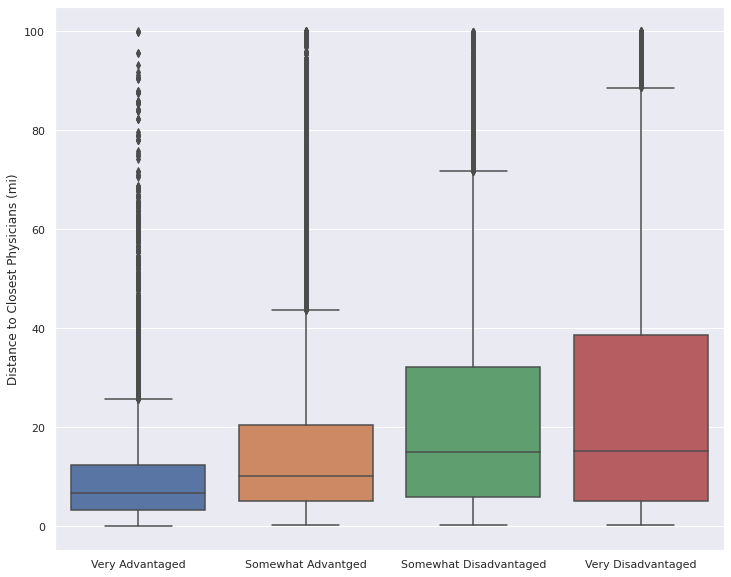

In [33]:
#Creating boxplot of data
plt.rcParams["figure.figsize"]=[12,10]
plot = sns.boxplot(data=hrr_dist, y="mi_to_tract", x="QUARTILE")
plot.set_ylabel("Distance to Closest Physicians (mi)")
plot.set_xticklabels(["Very Advantaged", "Somewhat Advantged", "Somewhat Disadvantaged", "Very Disadvantaged"])
plot.set_xlabel(None)
plt.savefig("Images/Analytic/hrr_dist_by_quartile_box.png", dpi=300)
plt.show()
# hrr_dist.boxplot("mi_to_tract", "QUARTILE")

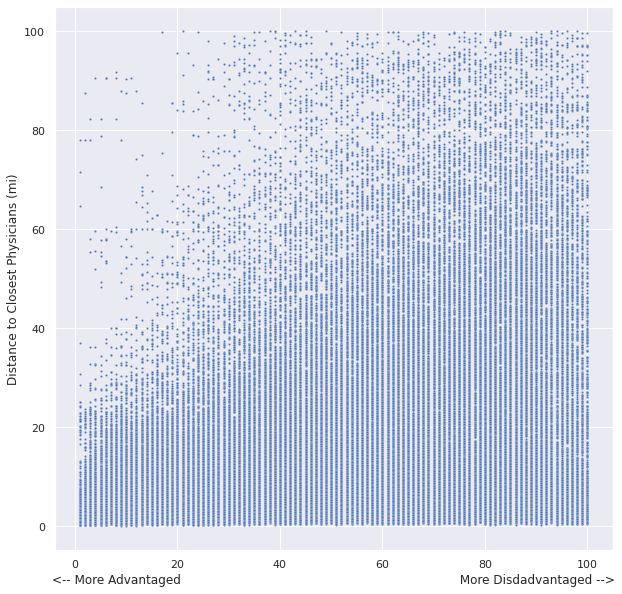

In [34]:
#Creating scatterplot of data
sns.set(rc={'figure.figsize':(10,10)})

plot = sns.scatterplot(data=hrr_dist, x="ADI_NATRANK", y="mi_to_tract", s=5)
plot.set_ylabel("Distance to Closest Physicians (mi)")
plot.set_xlabel("<-- More Advantaged                                                                        More Disdadvantaged -->")
plt.savefig("Images/Analytic/hrr_dist_scatter.png", dpi=300)
plt.show()

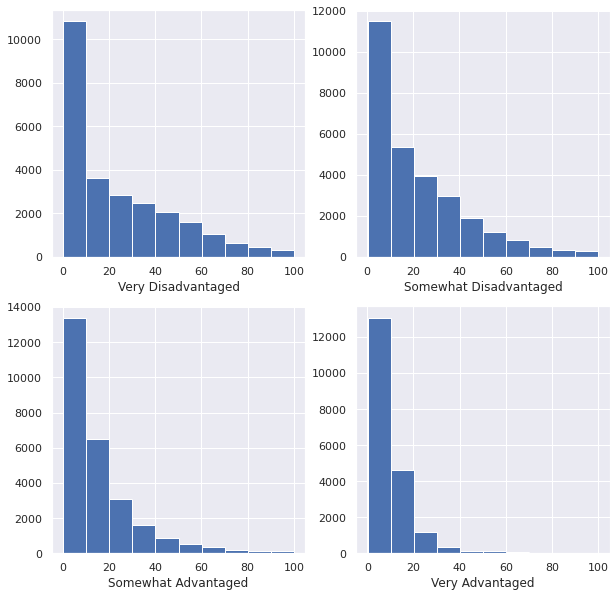

In [35]:
#Plotting histograms to check for normality
plt.subplot(2,2,1)
plt.hist(hrr_dist[hrr_dist["QUARTILE"] == 'VD']["mi_to_tract"])
plt.xlabel("Very Disadvantaged")
plt.subplot(2,2,2)
plt.hist(hrr_dist[hrr_dist["QUARTILE"] == 'SD']["mi_to_tract"])
plt.xlabel("Somewhat Disadvantaged")
plt.subplot(2,2,3)
plt.hist(hrr_dist[hrr_dist["QUARTILE"] == 'SA']["mi_to_tract"])
plt.xlabel("Somewhat Advantaged")
plt.subplot(2,2,4)
plt.hist(hrr_dist[hrr_dist["QUARTILE"] == 'VA']["mi_to_tract"])
plt.xlabel("Very Advantaged")
plt.show()

In [36]:
#As data is not normally distributed, nonparametric tests will be used
#Finding measures of central tendency...
def quarts(dists):
    return f"{round(dists.quantile(0.25), 2)}—{round(dists.quantile(0.75), 2)}" 

hrr_dist.groupby("QUARTILE").agg(
    count_of_tracts=("Rndrng_NPI", "count"),
    median_dist=("mi_to_tract", "median"),
    IQR_dist=("mi_to_tract", quarts)
)

,count_of_tracts,median_dist,IQR_dist
QUARTILE,,,
VA,19526,6.7014,3.33—12.3
SA,26664,10.1525,5.04—20.5
SD,28690,15.0170,5.85—32.21
VD,25840,15.2230,5.19—38.57


In [37]:
#Performing a Kruskall Wallis Test
VD_SD = stats.ttest_ind(hrr_dist[hrr_dist["QUARTILE"] == "VD"]["mi_to_tract"], hrr_dist[hrr_dist["QUARTILE"] == "SD"]["mi_to_tract"])
VA_VD = stats.ttest_ind(hrr_dist[hrr_dist["QUARTILE"] == "VD"]["mi_to_tract"], hrr_dist[hrr_dist["QUARTILE"] == "VA"]["mi_to_tract"])

ALL = stats.kruskal(*[group["mi_to_tract"].values for name, group in hrr_dist.groupby("QUARTILE")])

print("P VALUES")
print(f"VD_SD: {VD_SD}")
print(f"VA_VD: {VA_VD}")

print(f"overall: {ALL}")


P VALUES
VD_SD: Ttest_indResult(statistic=11.961447315291046, pvalue=6.220451230651332e-33)
VA_VD: Ttest_indResult(statistic=83.97406424294044, pvalue=0.0)
overall: KruskalResult(statistic=7136.0869887525905, pvalue=0.0)


# Step 4.1 (skipped)
### <s>Determine the neighborhoods closest to each physician</s>

Even though correcting for HRR produced very similar results to the raw data, we determined that the following analysis doesn't acount for many other parts of determining who patients actually went to.

In [38]:
#Group by physicians and describe what kind of neighborhoods they serve
physician_data = physician_dists.groupby(["Rndrng_NPI", "QUARTILE"]).agg(Total_neighborhoods=("FIPS", "count"))
physician_data = physician_data.reset_index()
physician_data = physician_data.pivot(index="Rndrng_NPI", columns= "QUARTILE", values = "Total_neighborhoods")
physician_data.columns=["VA", "SA", "SD", "VD"]
physician_data["Total"] = physician_data["VA"]+physician_data["SA"]+physician_data["SD"]+physician_data["VD"]
physician_data = physician_data.sort_values("Total")
physician_data

,VA,SA,SD,VD,Total
Rndrng_NPI,,,,,
1407887631,22,4,2,1,29
1205148707,3,16,12,22,53
1215952650,75,8,5,2,90
1164684643,11,57,40,6,114
1881702355,11,57,40,6,114
...,...,...,...,...,...
1326091927,405,752,977,881,3015
1922096817,133,552,1022,1385,3092
1982867636,133,552,1022,1385,3092


In [39]:
#Adjust data to show by tract
physician_data = physician_data.merge(claims_data, left_index=True, right_on="Rndrng_NPI")
physician_data = physician_data[["Rndrng_NPI", "Rndrng_Prvdr_Tract", "VA", "SA", "SD", "VD", "Total"]]
tract_data = physician_data.groupby("Rndrng_Prvdr_Tract").agg({"Rndrng_NPI":'count', "VA":'first', "SA":'first', "SD":'first', "VD":'first', "Total":'first'})
tract_data

,Rndrng_NPI,VA,SA,SD,VD,Total
Rndrng_Prvdr_Tract,,,,,,
10003013800,2,199,343,167,62,771
11001002302,3,697,455,45,8,1205
12001000902,1,9,52,92,156,309
12011090900,1,573,718,485,321,2097
12021010416,1,188,273,275,187,923
...,...,...,...,...,...,...
55079012800,1,116,251,146,56,569
55079017300,1,13,151,269,232,665
55079060102,1,58,149,106,149,462


In [40]:
#Adjust data to display PER HVS
adjusted_data = tract_data.copy()
adjusted_data["VA"] = round(adjusted_data["VA"] / adjusted_data["Rndrng_NPI"], 1)
adjusted_data["SA"] = round(adjusted_data["SA"] / adjusted_data["Rndrng_NPI"], 1)
adjusted_data["SD"] = round(adjusted_data["SD"] / adjusted_data["Rndrng_NPI"], 1)
adjusted_data["VD"] = round(adjusted_data["VD"] / adjusted_data["Rndrng_NPI"], 1)
adjusted_data.drop("Rndrng_NPI", inplace=True, axis=1)

adjusted_data

,VA,SA,SD,VD,Total
Rndrng_Prvdr_Tract,,,,,
10003013800,99.5,171.5,83.5,31.0,771
11001002302,232.3,151.7,15.0,2.7,1205
12001000902,9.0,52.0,92.0,156.0,309
12011090900,573.0,718.0,485.0,321.0,2097
12021010416,188.0,273.0,275.0,187.0,923
...,...,...,...,...,...
55079012800,116.0,251.0,146.0,56.0,569
55079017300,13.0,151.0,269.0,232.0,665
55079060102,58.0,149.0,106.0,149.0,462


/tmp/ipykernel_435610/4181214892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lorenz_data.loc[-1] = 0
/tmp/ipykernel_435610/4181214892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lorenz_data.loc[-1] = 0
/tmp/ipykernel_435610/4181214892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lorenz_data.loc[-1] = 0
/tmp/ipykernel_435610/4181214892.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

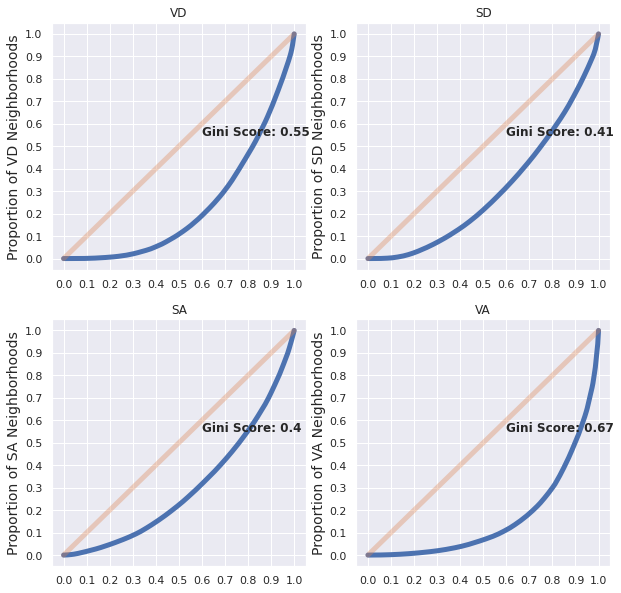

In [41]:
#Create lorenz curves for each quartile
#https://zhiyzuo.github.io/Plot-Lorenz/
def create_lorenz(dataset, colname):

    lorenz_data = dataset[[colname]]
    lorenz_data.loc[-1] = 0
    lorenz_data = lorenz_data.sort_values(colname).reset_index(drop=True)
    lorenz_data[colname] = lorenz_data[colname].cumsum() / lorenz_data[colname].sum()
    lorenz_data["Total HVS"] = lorenz_data.index / (len(lorenz_data) - 1)

    area_under_curve = np.trapz(lorenz_data[colname]) / len(lorenz_data)
    gini_score = 1- area_under_curve / 0.5

    plt.plot("Total HVS", colname,data=lorenz_data, linewidth=5)
    plt.plot(lorenz_data["Total HVS"], lorenz_data["Total HVS"], linewidth=5, alpha=0.35)
    plt.grid()
    plt.text(0.6, 0.55, f"Gini Score: {round(gini_score, 2)}", fontweight="bold", fontsize=12)

#     plt.xlabel("Proportion of Practices with at least one High-Volume Surgeon", fontsize=14)
    plt.grid()
    plt.ylabel(f"Proportion of {colname} Neighborhoods", fontsize=14)
    plt.xticks(np.array(range(11))/10)
    plt.yticks(np.array(range(11))/10)
    plt.title(colname)


    
    
plt.subplot(2,2,1)
create_lorenz(physician_data, "VD")
plt.subplot(2,2,2)
create_lorenz(physician_data, "SD")
plt.subplot(2,2,3)
create_lorenz(physician_data, "SA")
plt.subplot(2,2,4)
create_lorenz(physician_data, "VA")
    
plt.savefig(f"Images/Analytic/Tracts_by_Quartile.png", dpi=300, facecolor='white')
plt.show()